# k-NN k-Nearest Neighbours (k-Plus Proches Voisins)
<hr>
# Inspiré par : cours-IFT6390 - Automne 2021, sessions de laboratoir (matérial et code du cours sur les k-NN), démo 9 "librairie Scikit-learn"

In [1]:
import sklearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
import argparse
import pandas as pd

import gensim

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Outils

In [5]:
def make_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_file', type=str)
    parser.add_argument('--dev_file', type=str)
    parser.add_argument('--dataset_name', type=str)
    parser.add_argument('--representation', type=str)
    return parser

In [6]:
def read_data(file_name: str, dataset_name: str) -> pd.DataFrame:
    """
    Lecture des fichiers de données
    :param file_name: str, nom du fichier à lire
    :param dataset_name: str, nom du dataset auquel appartient le fichier
    :return: un dataframe pandas contenant une colonne "sentence" qui sont les exemples et une colonne "label" qui sont
    les labels associés aux exemples
    """
    # lecture fichier sous forme tsv
    if dataset_name == "cola":
        data = pd.read_csv(file_name, sep="\t", header=None)
    else:
        data = pd.read_csv(file_name, sep='\t')

    # standardization des données, i.e. création des colonnes 'sentence' et 'label' contenant les phrases exemples et
    # les classes associées
    if dataset_name == 'cola':
        data.columns = ["id", "label", "label2", "sentence"]
    elif dataset_name == 'qqp':
        data['sentence'] = data.apply(
            lambda row: row['question1'] + ' ' + row['question2'], axis=1)
        data = data.rename(columns={'is_duplicate': 'label'})

    return data

In [7]:
def read_corpus(data):
    for i, line in enumerate(data["sentence"]):
        tokens = gensim.utils.simple_preprocess(line)
        yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [39]:
def convert_to_matrix(corpus, data, vector_size=30):
    model = gensim.models.doc2vec.Doc2Vec(
        vector_size=vector_size, min_count=2, epochs=40)
    model.build_vocab(corpus)
    model.train(corpus, total_examples=model.corpus_count,
                epochs=model.epochs)
    sentence2vec = [model.infer_vector((data["sentence"][i].split(
        " "))) for i in range(0, len(data["sentence"]))]
    stv = np.array(sentence2vec)

    return stv

In [55]:
categories = [0, 1]

def train_model(X_train, y_train, X_dev, y_dev, k_nn = 10):
    k_values = np.arange(1, k_nn, 2)
    k_test = []
    k_train = []
    for k in k_values:
        knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                            metric_params=None, n_jobs=None, n_neighbors=k, p=2,
                            weights='uniform')
        knn.fit(X_train, y_train)

        train_pred = knn.predict(X_train)
        k_train.append((train_pred == y_train).mean())
        test_pred = knn.predict(X_dev)
        k_test.append((test_pred == y_dev).mean())

    plt.xlabel('k\'s value')
    plt.ylabel('Performance')
    plt.plot(k_values, k_test, label='test set',color='b')
    plt.plot(k_values, k_train, label='train_set',color='r')
    
    return k_train, k_test

In [44]:
def test_model(model, X_test, y_test):
    # Évaluation du modèle sur les données de test

    print("Testing model")
    y_pred = model.predict(X_test)

    acc = classification_report(y_test, y_pred)
    print("Accuracy on dev set", acc)

# Jupyter Notebook Main
<hr>
# Pour l'execution dans l'environnement Jupyter


In [34]:
# Les arguments (paramètres) d'execution...
# PARAMÈTRES D'EXECUTION
# '--train_file', type=str)
# '--dev_file', type=str)
# '--dataset_name', type=str)
## '--representation', type=str)

# Paramètres (locales) pour SST, au lieu d'utiliser' make_parser(sys.argv[1:])  :
strTrainFile = "C:/UdeM-ws/ift6285_taln/project1/data/sst_train.tsv"
strDevFile = "C:/UdeM-ws/ift6285_taln/project1/data/sst_dev.tsv"
strDataSet = "sst"

train_file = strTrainFile
dev_file = strDevFile
dataset_name = strDataSet
# representation = args.representation

In [40]:
# Input data
print("Reading data, preprocessing...")

# lire les fichiers
train_data = read_data(train_file, dataset_name)
## représentations word2vec
train_corpus = list(read_corpus(train_data))

X_train = convert_to_matrix(train_corpus, train_data)
y_train = train_data["label"].to_numpy()

Reading data, preprocessing...


In [41]:
test_data = read_data(dev_file, dataset_name)
test_corpus = list(read_corpus(test_data))

X_test = convert_to_matrix(test_corpus, test_data)
y_test = test_data["label"].to_numpy()

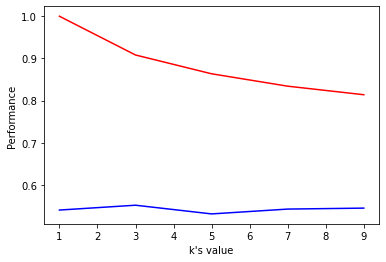

In [56]:
# Model training and prediction
knn_train, knn_test = train_model(X_train, y_train, X_test, y_test)

In [60]:
print(f'knn_parameter : {np.arange(1, 10, 2)}')
print(f'knn_train performance : {knn_train}')
print(f'knn_test performance : {knn_test}')

knn_parameter : [1 3 5 7 9]
knn_train performance : [1.0, 0.9080461476785104, 0.8634575123609853, 0.8340584121516281, 0.8137908506436621]
knn_test performance : [0.5401376146788991, 0.551605504587156, 0.5309633027522935, 0.5424311926605505, 0.5447247706422018]


# Main
<hr>